# Úvod

![mood](https://miro.medium.com/v2/resize:fit:518/format:webp/1*iEkoBTURLU8t2NYeOPTIYw.jpeg)

Vybral jsem si dataset **Action-Camera Parking Dataset** ([ACPDS](https://arxiv.org/abs/2107.12207)). Tento dataset je
zaměřen na detekci obsazenosti parkovacích míst a byl vytvořen s cílem poskytnout různorodé a realistické snímky
parkovišť a ulic na rozdíl od statických kamerových systémů.

Pro vytvoření datové sady ACPDS autoři použili kameru _GoPro Hero 6_, kterou připevnili na **12 metrů** dlouhou
teleskopickou tyč. Tímto způsobem získali možnost zachytit různá parkoviště a ulice z jedinečných pohledů, které
klasické přístupy monitorování nemohou poskytnout.

Fotografie byly pořízeny z výšky již zmíněných 12 metrů, což odpovídá běžné výšce pouličních lamp. Tato vlastnost je
velmi důležitá pro praktické použití, protože fotografie budou lépe odrážet reálné situace, které mohou nastat. Celkově
autoři zachytili 293 snímků v rozlišení **4000x3000** pixelů.

[Odkaz](https://github.com/martin-marek/parking-space-occupancy) na GitHub repozitář autorů s všemi potřebnými
informacemi a soubory.


# Načtení knihoven


In [1]:
import io
import os
import random
import zipfile

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import cv2

# Stažení a načtení dat


In [2]:
dataset_dir = 'data/parking_dataset'
download_url = 'https://pub-e8bbdcbe8f6243b2a9933704a9b1d8bc.r2.dev/parking%2Frois_gopro.zip'

In [3]:
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    with requests.get(download_url, stream=True) as response:
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte
        t = tqdm.tqdm(total=total_size, unit='iB', unit_scale=True)
        buffer = io.BytesIO()
        for data in response.iter_content(block_size):
            t.update(len(data))
            buffer.write(data)
        t.close()
        if total_size != 0 and t.n != total_size:
            print("ERROR, something went wrong")
        buffer.seek(0)
        zip = zipfile.ZipFile(buffer)
    zip.extractall(dataset_dir)
    print('Data downloaded and extracted')
else:
    print('Data already exists')

Data already exists


In [4]:
print(os.listdir(dataset_dir))

['annotations.json', 'images']


Stažený zip archiv obsahuje následující složky a soubory:

- `images` - složka obsahující fotografie parkovišť
- `annotations.json` - soubor obsahující anotace k fotografiím k jednotlivým parkovištím

Pojďme se na ně podívat.


# Fotografie parkovišť

Jednotlivé snímky jsou uloženy ve složce `images`. Nyní si zobrazíme několik z nich.


In [5]:
images_dir = os.path.join(dataset_dir, 'images')

In [6]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [7]:
len(os.listdir(images_dir))

293

Dostáváme přesně stejný počet snímků, jaký byl zmíněn autory v datasetu. Paráda!


## Vizualizace snímků


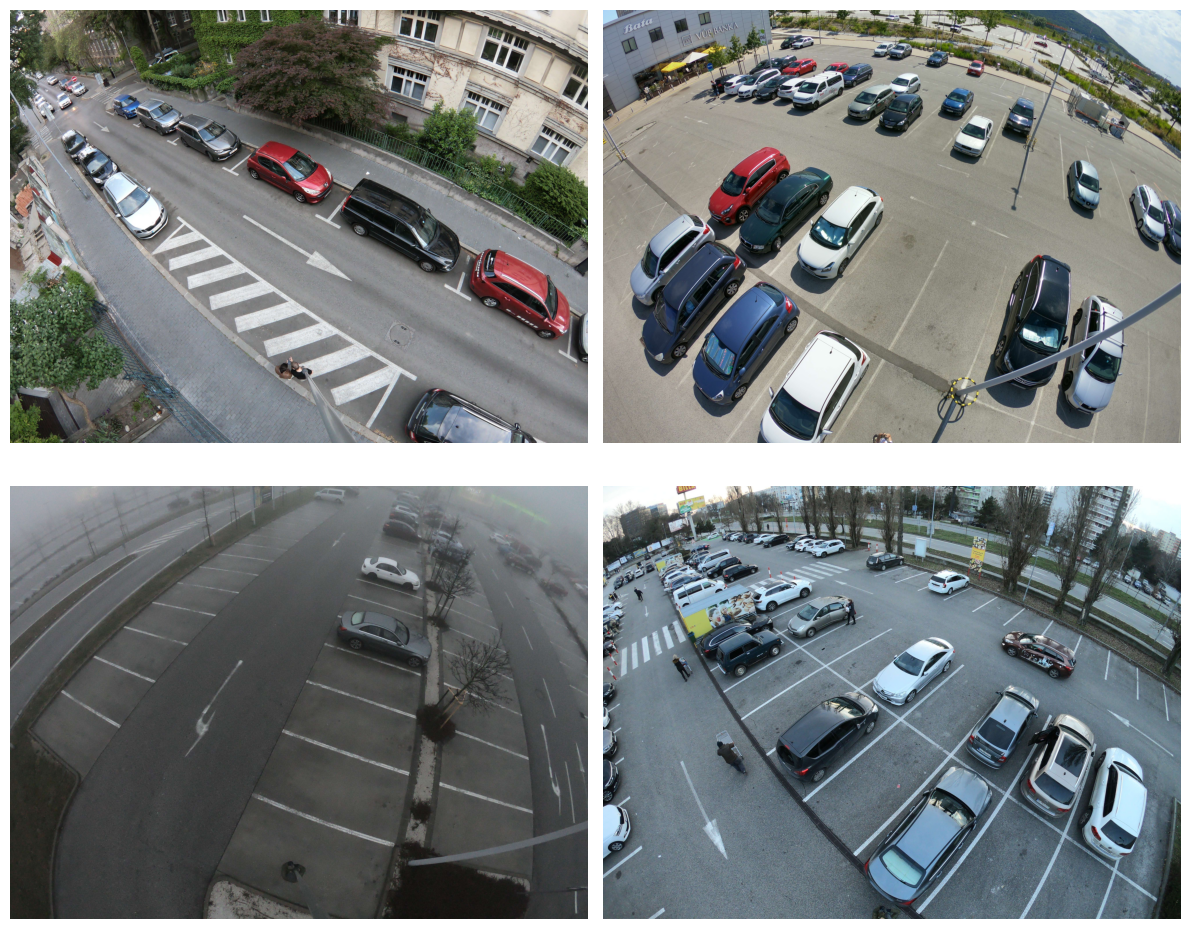

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

random_images = random.sample(os.listdir(images_dir), 4)

for i, img_name in enumerate(random_images):
    image_path = os.path.join(images_dir, img_name)
    image = load_image(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Jsou to převážně parkoviště u obchodů, která jsou vidět zhruba z výšky zmíněných 12 metrů. Jsou mírně rozostřené ptačí
perspektivou, ale stále je možné rozpoznat jednotlivá auta. Koneckonců, to je hlavní cíl tohoto datasetu, mít pestré a
reálné data. Jednotlivá místa jsou označena pomocí anotací s tímto mírným rozostřením.


# Anotace

Anotace jsou stejně důležité jako samotné fotografie. Bez nich by bylo obtížné využít tento dataset pro trénování modelů
strojového učení. Anotace obsahují informace o jednotlivých parkovacích místech, jako je jejich poloha, velikost a
obsazenost.

Bez nich by nebylo možné trénovat modely a říct jim, co mají dělat, jaké jsou jejich cíle a jaké jsou výsledky. Anotace
jsou tedy klíčovým prvkem datasetu.

Anotace nebudou tak přímočaré, jak by se mohlo zdát. Podívejme se na ně podívat podrobněji a zjistit, jaké informace
obsahují. Jsou uloženy v souboru `annotations.json`.


In [9]:
json_annotations = pd.read_json(os.path.join(dataset_dir, 'annotations.json'))
json_annotations.head()

test  \
file_names      [GOPR6543.JPG, GOPR6538.JPG, GOPR6536.JPG, GOP...   
occupancy_list  [[False, False, False, False, False, False, Fa...   
rois_list       [[[[0.04382425, 0.7564296666666661], [0.0, 0.8...   

                                                            train  \
file_names      [GOPR0025.JPG, GOPR6545.JPG, GOPR0031.JPG, GOP...   
occupancy_list  [[True, True, True, False, True, True, True, T...   
rois_list       [[[[0.3330645, 0.518279666666666], [0.2903225,...   

                                                            valid  
file_names      [GOPR6590.JPG, GOPR6593.JPG, GOPR6596.JPG, GOP...  
occupancy_list  [[False, False, False, True, False, True, Fals...  
rois_list       [[[[0.8079095, 0.998430666666666], [0.6694915,...

In [10]:
print("\nColumns:", json_annotations.columns.tolist())
print("\nIndex:", json_annotations.index.tolist())

for column in json_annotations.columns:
    print(f"\n{column}:")
    for idx in json_annotations.index:
        data = json_annotations.loc[idx, column]
        print(f"\t{idx}: {len(data)} items")
        if len(data) > 0 and isinstance(data[0], list):
            print(f"\t\tFirst item contains {len(data[0])} elements")


Columns: ['test', 'train', 'valid']

Index: ['file_names', 'occupancy_list', 'rois_list']

test:
	file_names: 27 items
	occupancy_list: 27 items
		First item contains 76 elements
	rois_list: 27 items
		First item contains 76 elements

train:
	file_names: 231 items
	occupancy_list: 231 items
		First item contains 13 elements
	rois_list: 231 items
		First item contains 13 elements

valid:
	file_names: 35 items
	occupancy_list: 35 items
		First item contains 69 elements
	rois_list: 35 items
		First item contains 69 elements


Zde vidíme, že anotace obsahují následující informace:

- **rozdělení dat** - informace o tom, zda je fotografie součástí trénovacího, validačního nebo testovacího datasetu,
  zde je důležité podotknout, že všechny data jsou uložená v listu přes který budeme přistupovat iterativně
  - **názvy souborů** - názvy fotografií, které jsou součástí dané množiny dat
  - **ROIS (region of interest)** - oblasti zájmu, které byly anotovány autory datasetu, reprezentované jako čtyři
    souřadnice _(x1, y1, x2, y2)_
  - **stav parkovacího místa** - informace o tom, zda je parkovací místo obsazené nebo volné, list hodnot `True` nebo
    `False`

Důležité je správně pochopit, jak jsou tyto informace strukturovány, abychom mohli správně použít tento dataset pro
trénování modelů.


## Vizualizace anotací na fotografii


Selected file: GOPR6766.JPG
Number of parking spaces: 60
Occupied spaces: 27
Free spaces: 33


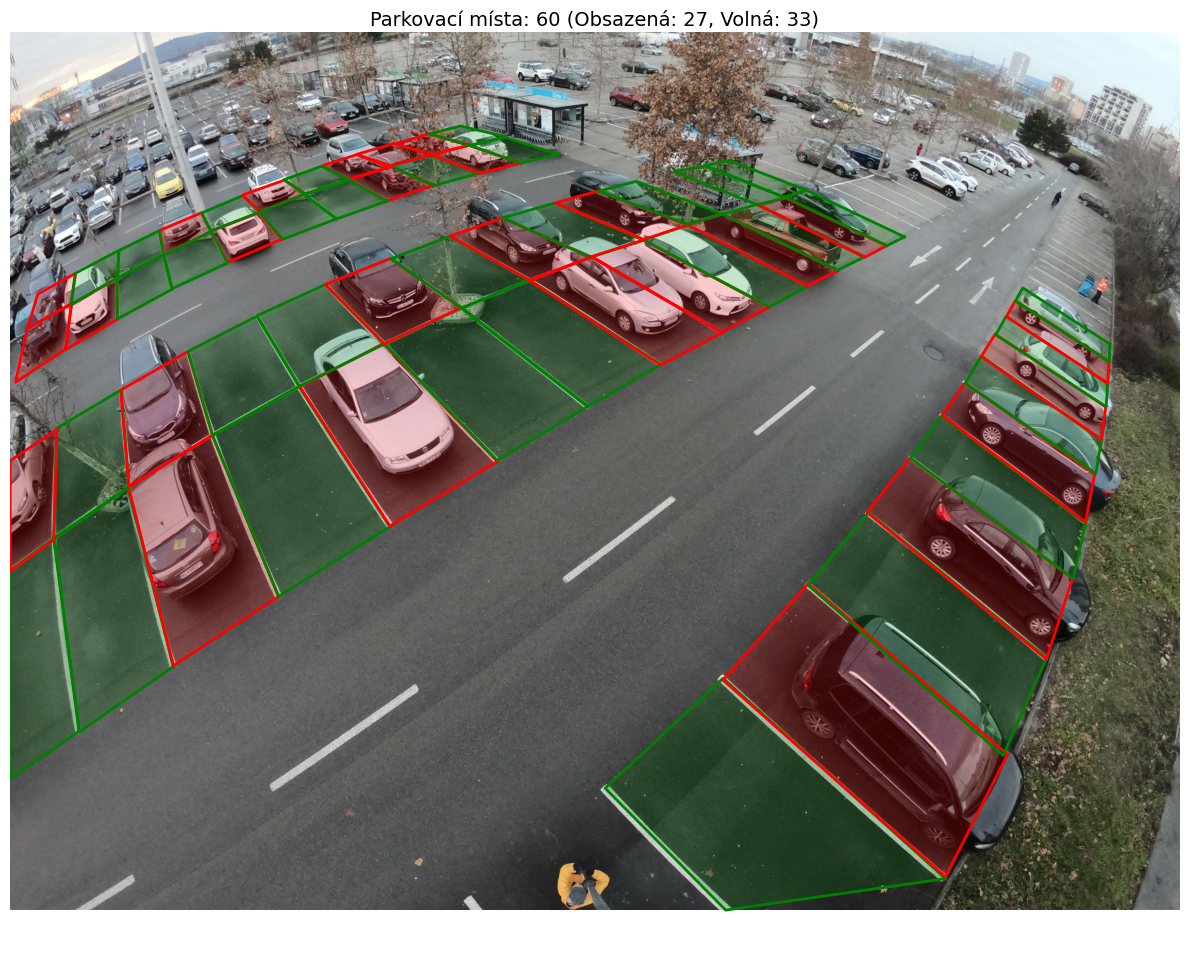

In [11]:
random_pick_file = random.choice(json_annotations['train']['file_names'])
print(f"Selected file: {random_pick_file}")

idx = json_annotations['train']['file_names'].index(random_pick_file)
rois = json_annotations['train']['rois_list'][idx]
occupancy = json_annotations['train']['occupancy_list'][idx]

print(f"Number of parking spaces: {len(occupancy)}")
print(f"Occupied spaces: {occupancy.count(True)}")
print(f"Free spaces: {occupancy.count(False)}")

image_path = os.path.join(images_dir, random_pick_file)
image = load_image(image_path)

plt.figure(figsize=(12, 10))
plt.imshow(image)

for i in range(len(rois)):
    roi = np.array(rois[i])
    is_occupied = occupancy[i]
    edge_color = 'red' if is_occupied else 'green'
    fill_color = ('red' if is_occupied else 'green', 0.2)  # transparency

    # Scale the ROI coordinates to match the image size
    x = roi[:, 0] * image.shape[1]
    y = roi[:, 1] * image.shape[0]

    plt.plot(np.append(x, x[0]), np.append(y, y[0]), color=edge_color, linewidth=2)
    plt.fill(x, y, color=fill_color)

plt.axis('off')
plt.title(
    f"Parkovací místa: {
        len(occupancy)} (Obsazená: {
            occupancy.count(True)}, Volná: {
                occupancy.count(False)})",
    fontsize=14)
plt.tight_layout()
plt.show()

## Získání výřezů jednotlivých míst z fotografií


In [12]:
def cut_rois(image, rois):
    roi_images = []
    for roi in rois:
        roi_np = np.array(roi)

        x_min = int(min(roi_np[:, 0]) * image.shape[1])
        y_min = int(min(roi_np[:, 1]) * image.shape[0])
        x_max = int(max(roi_np[:, 0]) * image.shape[1])
        y_max = int(max(roi_np[:, 1]) * image.shape[0])

        roi_image = image[y_min:y_max, x_min:x_max]
        roi_images.append(roi_image)

    return roi_images

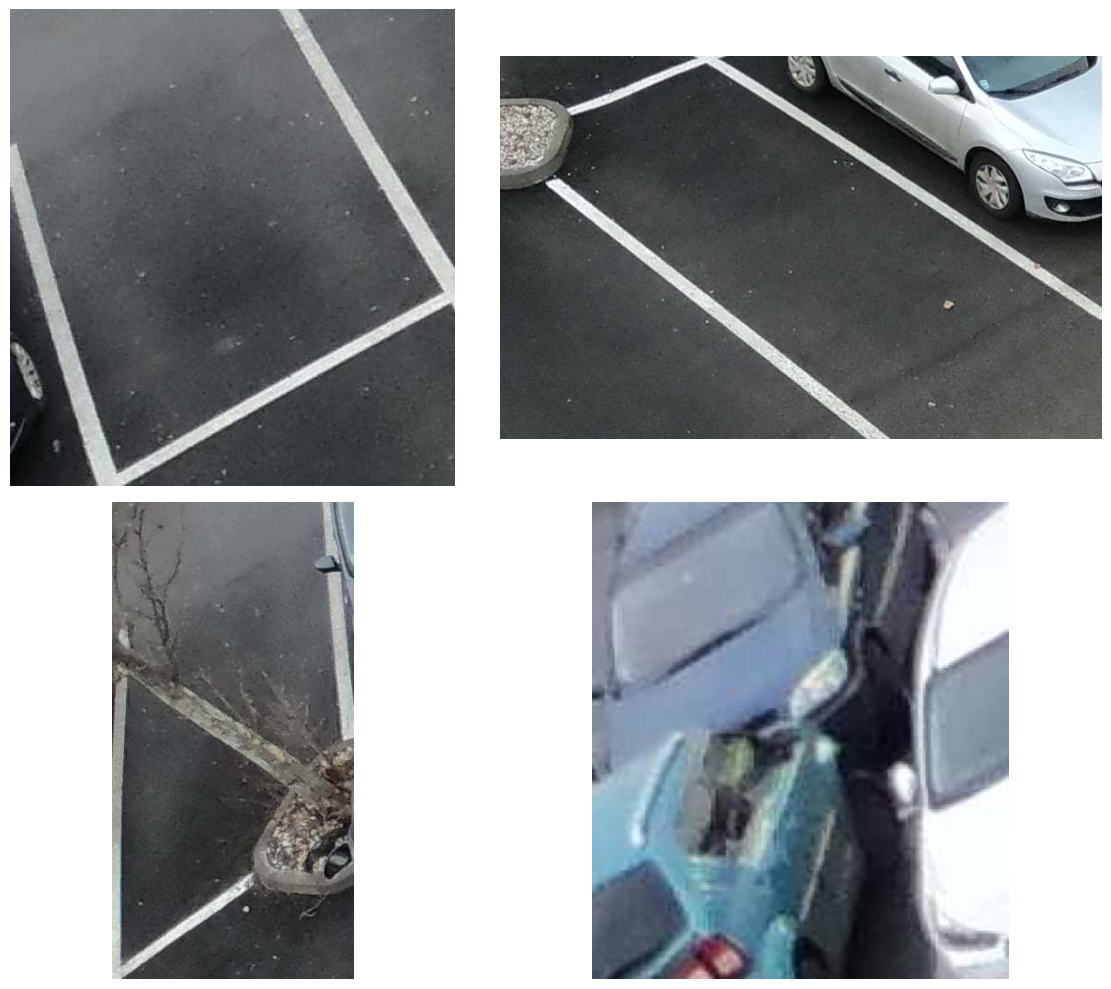

In [13]:
roi_images = cut_rois(image, rois)
random_choices = random.sample(range(len(roi_images)), 4)
selected_roi_images = [roi_images[i] for i in random_choices]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(4):
    axes[i].imshow(selected_roi_images[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Vidíme, že jednotlivé výřezy mají různé velikosti a tvary. Pojďme se na ně podívat.


# Získání statistik o výřezech


In [14]:
def analyze_dataset(annotations, images_dir):
    dimensions = {'train': [], 'valid': [], 'test': []}
    total_rois = {}
    class_balance = {}

    for split in ['train', 'valid', 'test']:
        all_heights = []
        all_widths = []

        rois_count = sum(len(rois) for rois in annotations[split]['rois_list'])
        total_rois[split] = rois_count

        occupied = 0
        for idx, file_name in enumerate(annotations[split]['file_names']):
            occupancy_list = annotations[split]['occupancy_list'][idx]
            occupied += occupancy_list.count(True)

            image_path = os.path.join(images_dir, file_name)
            image = load_image(image_path)
            rois = annotations[split]['rois_list'][idx]

            roi_images = cut_rois(image, rois)

            for roi in roi_images:
                all_heights.append(roi.shape[0])
                all_widths.append(roi.shape[1])

        dimensions[split] = {
            'avg_height': np.mean(all_heights) if all_heights else 0,
            'avg_width': np.mean(all_widths) if all_widths else 0,
            'std_height': np.std(all_heights) if all_heights else 0,
            'std_width': np.std(all_widths) if all_widths else 0,
            'min_height': min(all_heights) if all_heights else 0,
            'max_height': max(all_heights) if all_heights else 0,
            'min_width': min(all_widths) if all_widths else 0,
            'max_width': max(all_widths) if all_widths else 0
        }

        unoccupied = rois_count - occupied
        class_balance[split] = {
            'occupied': occupied,
            'unoccupied': unoccupied,
            'occupied_percentage': (occupied / rois_count) * 100 if rois_count > 0 else 0,
            'unoccupied_percentage': (unoccupied / rois_count) * 100 if rois_count > 0 else 0
        }

    total_roi_count = sum(total_rois.values())
    split_percentages = {}
    for split, count in total_rois.items():
        split_percentages[split] = (count / total_roi_count) * 100

    return {
        'dimensions': dimensions,
        'total_rois': total_rois,
        'total_roi_count': total_roi_count,
        'split_percentages': split_percentages,
        'class_balance': class_balance
    }

In [15]:
roi_stats = analyze_dataset(json_annotations, images_dir)

## Rozměry výřezů

Jak jsme si ukázali, výřezy mají různé rozměry. Pro model musíme nastavit uniformní rozměry, abychom mohli použít
konvoluční neuronové sítě. Pojďme se podívat, jaké rozměry mají jednotlivé výřezy a jak je můžeme upravit.


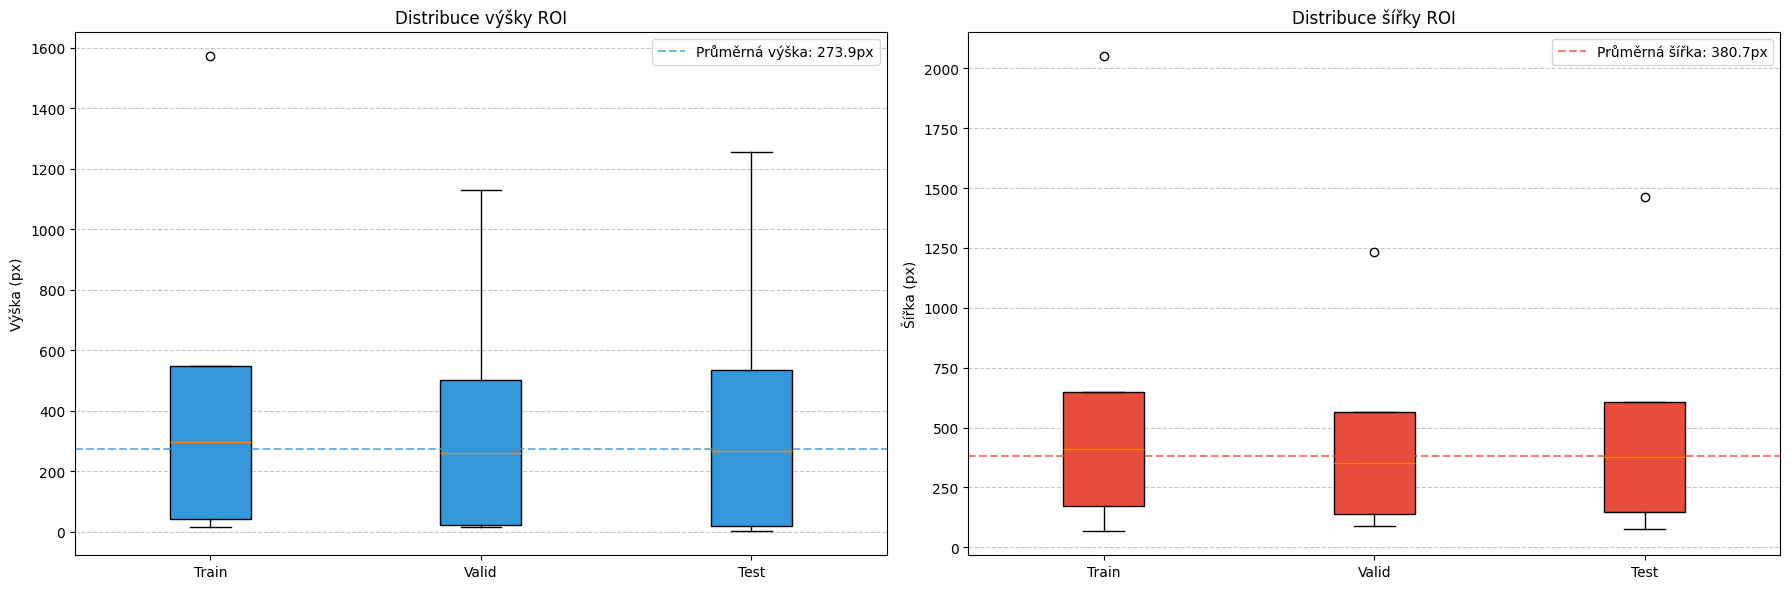

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
dimensions = roi_stats['dimensions']
labels = list(dimensions.keys())

height_data = [[dimensions[split]['min_height'],
                dimensions[split]['avg_height'] - dimensions[split]['std_height'],
                dimensions[split]['avg_height'],
                dimensions[split]['avg_height'] + dimensions[split]['std_height'],
                dimensions[split]['max_height']] for split in labels]

bplot1 = ax1.boxplot(height_data, patch_artist=True)
for patch in bplot1['boxes']:
    patch.set_facecolor('#3498db')

avg_height = np.mean([dimensions[split]['avg_height'] for split in labels])
ax1.axhline(y=avg_height, color='#3498db', linestyle='--', alpha=0.7,
            label=f'Průměrná výška: {avg_height:.1f}px')

ax1.set_ylabel('Výška (px)')
ax1.set_title('Distribuce výšky ROI')
ax1.set_xticklabels([s.capitalize() for s in labels])
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend()

width_data = [[dimensions[split]['min_width'],
               dimensions[split]['avg_width'] - dimensions[split]['std_width'],
               dimensions[split]['avg_width'],
               dimensions[split]['avg_width'] + dimensions[split]['std_width'],
               dimensions[split]['max_width']] for split in labels]

bplot2 = ax2.boxplot(width_data, patch_artist=True)
for patch in bplot2['boxes']:
    patch.set_facecolor('#e74c3c')

avg_width = np.mean([dimensions[split]['avg_width'] for split in labels])
ax2.axhline(y=avg_width, color='#e74c3c', linestyle='--', alpha=0.7,
            label=f'Průměrná šířka: {avg_width:.1f}px')

ax2.set_ylabel('Šířka (px)')
ax2.set_title('Distribuce šířky ROI')
ax2.set_xticklabels([s.capitalize() for s in labels])
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

Vidíme, že máme jedno odlehlé pozorování pro každou z daných sad. Možná to byl jen špatný snímek, špatná anotace nebo
záměr autora.

Vzhledem k tomu, že máme pouze 293 snímků, je dobré mít co nejvíce dat pro trénink modelu. Myslím si, že to je záměr
autora, aby se model naučil rozpoznávat i špatné snímky. Dosti napovídá i to, že se nachází jedno odlehlé pozorování pro
každou z daných sad.


### Úvaha nad rozměry pro model

Pravidlo pro velikosti výřezů je jednoduché - čím větší rozměr, tím více detailů a informací model získá. Na druhou
stranu, čím větší rozměr, tím více výpočetní náročnosti a paměti model potřebuje. Je tedy potřeba najít kompromis mezi
těmito dvěma faktory.

Pravidlo palce je použít stejné rozměry násobků **32**.

Na výběr máme několik možností:

- **224x224** - standardní velikost pro modely jako ResNet, VGG, EfficientNet - je to de facto standard pro CNN, je zde
  dobrý poměr mezi výpočetní náročností a kvalitou.
- **256x256** - mírně vyšší rozlišení, které může zachovat více detailů, ale stále je výpočetně efektivní.
- **320x320** - vhodné pro modely, kde je potřeba zachovat více informací, především pokud jsou parkovací místa menší a
  detailnější.

Pokud se podíváme na průměrnou výšku a šířku výřezů, možná se nám podaří najít nějaký kompromis.


In [17]:
print(f"Průměrná výška: {avg_height:.1f}px")
print(f"Průměrná šířka: {avg_width:.1f}px")

Průměrná výška: 273.9px
Průměrná šířka: 380.7px


Omlouvám se, není to úplně košer, ale pokud vezmene průměrnou výšku a šířku a získáme jejich průměr, dostaneme se na
potenciální rozměr.


In [18]:
print((avg_height + avg_width) / 2)

327.3163150399976


Dobře, dostali jsme 327, což je nejblíže 320. Budeme mít tedy rozměr **320x320**. Zachováme tak více detailů za cenu
výpočetní a časové náročnosti.


In [20]:
IMAGE_SIZE = 320

## Testovací, validační a trénovací množina

To, že máme 293 fotografií, neznamená, že máme 293 vstupů pro trénink modelu. Jak bylo zmíněno výše, každá fotografie
obsahuje různé výřezy, které jsou anotovány. Tím, že každá fotografie je unikátní, nevíme přesně poměr trénovací a
testovací množiny. Pojďme to zjistit.


In [21]:
def get_total_rois(annotations):
    total_rois = {}
    class_balance = {}

    for split in ['train', 'valid', 'test']:
        rois_count = sum(len(rois) for rois in annotations[split]['rois_list'])
        total_rois[split] = rois_count

        occupied = 0
        for occupancy_list in annotations[split]['occupancy_list']:
            occupied += occupancy_list.count(True)

        unoccupied = rois_count - occupied

        class_balance[split] = {
            'occupied': occupied,
            'unoccupied': unoccupied,
            'occupied_percentage': (occupied / rois_count) * 100 if rois_count > 0 else 0,
            'unoccupied_percentage': (unoccupied / rois_count) * 100 if rois_count > 0 else 0
        }

    return total_rois, class_balance

In [22]:
total_rois, class_balance = get_total_rois(json_annotations)
print("Total ROIs per split:", total_rois)

Total ROIs per split: {'train': 7842, 'valid': 1904, 'test': 1490}


In [23]:
total_roi_count = sum(total_rois.values())
print(f"Total number of ROIs across all splits: {total_roi_count}")

Total number of ROIs across all splits: 11236


In [24]:
for split, count in total_rois.items():
    percentage = (count / total_roi_count) * 100
    print(f"{split}: {count} ROIs ({percentage:.2f}%)")

train: 7842 ROIs (69.79%)
valid: 1904 ROIs (16.95%)
test: 1490 ROIs (13.26%)


Autoři datasetu se snažili o rozdělení mezi trénovací, validační a testovací množinou v poměru 70/15/15. Je to asi
nejvíce používaný poměr pro rozdělení dat. Vidíme, že poměr je dodržen, ale je zde mírná odchylka me zi validační a
testovací množinou v prospěch validační množiny. **(17% vs 13%)**


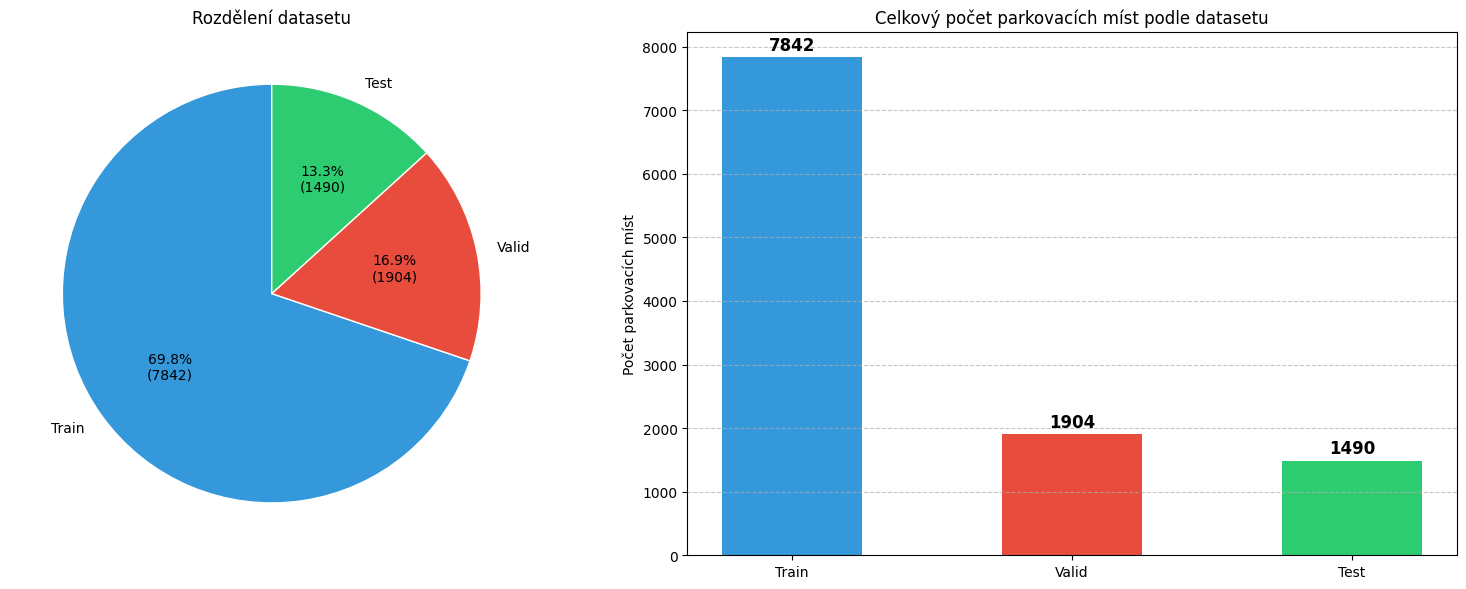

In [25]:
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))

labels = list(roi_stats['split_percentages'].keys())
sizes = list(roi_stats['split_percentages'].values())

wedges, texts, autotexts = axes1[0].pie(
    sizes, labels=[s.capitalize() for s in labels],
    autopct='%1.1f%%', startangle=90,
    colors=['#3498db', '#e74c3c', '#2ecc71'],
    wedgeprops={'edgecolor': 'w', 'linewidth': 1})

# Add exact number of samples
for i, autotext in enumerate(autotexts):
    split = labels[i]
    count = roi_stats['total_rois'][split]
    autotext.set_text(f"{autotext.get_text()}\n({count})")

axes1[0].set_title('Rozdělení datasetu')

total_counts = [roi_stats['total_rois'][split] for split in labels]
x = np.arange(len(labels))

bars = axes1[1].bar(x, total_counts, width=0.5, color=['#3498db', '#e74c3c', '#2ecc71'])

# Add the exact count on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes1[1].text(bar.get_x() + bar.get_width() / 2, height + 50,
                  f'{total_counts[i]}',
                  ha='center', va='bottom', fontsize=12, fontweight='bold')

axes1[1].set_ylabel('Počet parkovacích míst')
axes1[1].set_title('Celkový počet parkovacích míst podle datasetu')
axes1[1].set_xticks(x)
axes1[1].set_xticklabels([s.capitalize() for s in labels])
axes1[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Rovnováha jednotlivých tříd


In [26]:
for split, balance in class_balance.items():
    print(f"{split}:")
    print(f"\tOccupied: {balance['occupied']} ({balance['occupied_percentage']:.2f}%)")
    print(f"\tUnoccupied: {balance['unoccupied']} ({balance['unoccupied_percentage']:.2f}%)")

train:
	Occupied: 3940 (50.24%)
	Unoccupied: 3902 (49.76%)
valid:
	Occupied: 831 (43.64%)
	Unoccupied: 1073 (56.36%)
test:
	Occupied: 605 (40.60%)
	Unoccupied: 885 (59.40%)


Jednotlivé třídy jsou v datasetu slušně vyvážené. Pro trénování modelu máme skoro perfektní poměr 50:50 v **trénovací
množině**.

V **testovací množině** je to horší, ale stále je to slušné, poměr 43:57 pro prospěch neobsazených míst.

V **validační množině** je to strošilinku horší, ale stále je to slušné, poměr 40:60 pro prospěch obsazených míst.

Nemyslím si, že to bude mít vliv na trénink modelu, protože máme dostatek dat pro obě třídy. Proto jsem se rozhodl
neprovádět žádné úpravy a ponechat to tak, jak to je. Pokud by během tréninku modelu docházelo k určení pouze jedné
třídy, pak bychom museli provést úpravy.

Pro přehlednost jsou dostupné grafy níže.


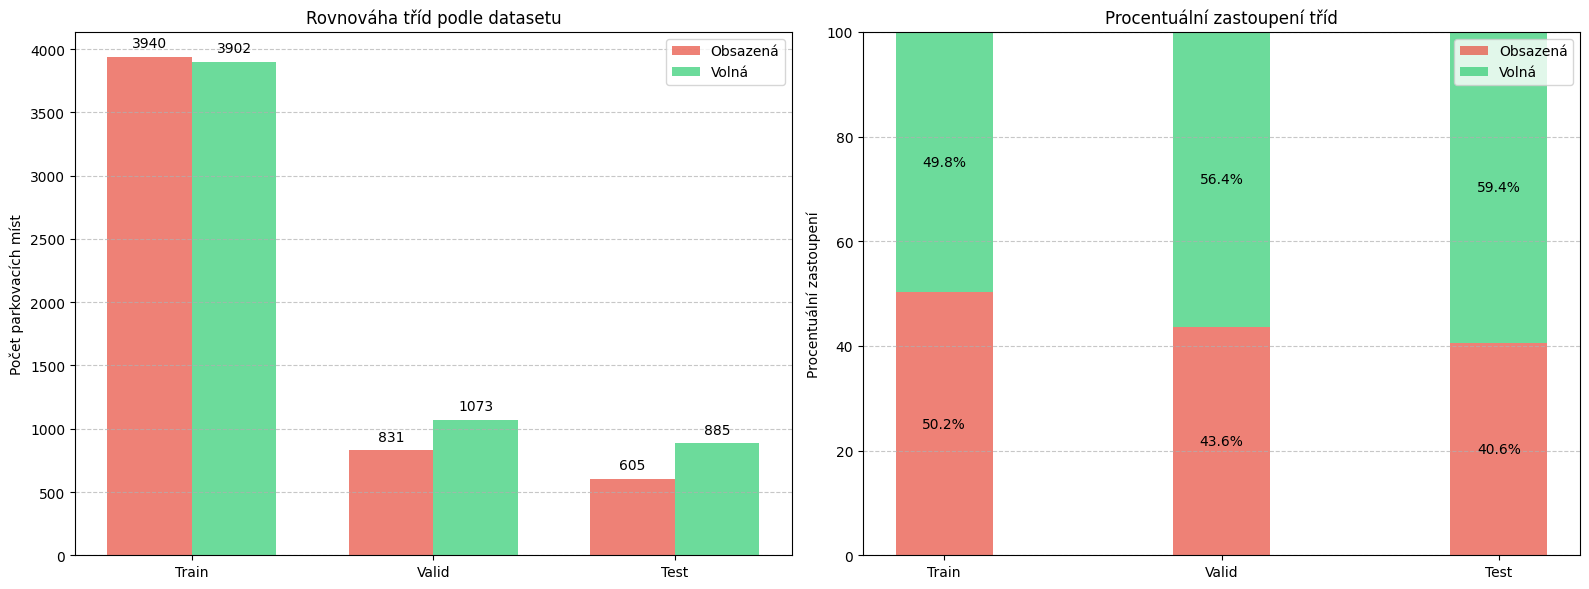

In [27]:
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

class_balance = roi_stats['class_balance']
labels = list(class_balance.keys())
occupied = [class_balance[split]['occupied'] for split in labels]
unoccupied = [class_balance[split]['unoccupied'] for split in labels]

x = np.arange(len(labels))
width_bar = 0.35

bars1 = axes2[0].bar(x - width_bar / 2, occupied, width_bar, label='Obsazená', color='#e74c3c', alpha=0.7)
bars2 = axes2[0].bar(x + width_bar / 2, unoccupied, width_bar, label='Volná', color='#2ecc71', alpha=0.7)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes2[0].text(bar.get_x() + bar.get_width() / 2, height + 50,
                  f'{occupied[i]}',
                  ha='center', va='bottom', fontsize=10)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes2[0].text(bar.get_x() + bar.get_width() / 2, height + 50,
                  f'{unoccupied[i]}',
                  ha='center', va='bottom', fontsize=10)

axes2[0].set_ylabel('Počet parkovacích míst')
axes2[0].set_title('Rovnováha tříd podle datasetu')
axes2[0].set_xticks(x)
axes2[0].set_xticklabels([s.capitalize() for s in labels])
axes2[0].legend()
axes2[0].grid(axis='y', linestyle='--', alpha=0.7)

occupied_pct = [class_balance[split]['occupied_percentage'] for split in labels]
unoccupied_pct = [class_balance[split]['unoccupied_percentage'] for split in labels]

bars3 = axes2[1].bar(x, occupied_pct, width_bar, label='Obsazená', color='#e74c3c', alpha=0.7)
bars4 = axes2[1].bar(x, unoccupied_pct, width_bar, bottom=occupied_pct, label='Volná', color='#2ecc71', alpha=0.7)

for i, bar in enumerate(bars3):
    height = bar.get_height() / 2
    axes2[1].text(bar.get_x() + bar.get_width() / 2, height,
                  f'{occupied_pct[i]:.1f}%',
                  ha='center', va='center', fontsize=10, color='black')

for i, bar in enumerate(bars4):
    y_pos = occupied_pct[i] + unoccupied_pct[i] / 2
    axes2[1].text(bar.get_x() + bar.get_width() / 2, y_pos,
                  f'{unoccupied_pct[i]:.1f}%',
                  ha='center', va='center', fontsize=10, color='black')

axes2[1].set_ylabel('Procentuální zastoupení')
axes2[1].set_title('Procentuální zastoupení tříd')
axes2[1].set_xticks(x)
axes2[1].set_xticklabels([s.capitalize() for s in labels])
axes2[1].set_ylim(0, 100)
axes2[1].legend()
axes2[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()